In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from collections import Counter
import os
import sys
import re
import subprocess
import MeCab
import warnings
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, roc_auc_score

In [2]:
warnings.filterwarnings('ignore')
tqdm.pandas()
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 150)
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']

cmd = 'echo `mecab-config --dicdir`"/mecab-ipadic-neologd"'
path = (subprocess.Popen(cmd, stdout=subprocess.PIPE,
                           shell=True).communicate()[0]).decode('utf-8')
m = MeCab.Tagger("-d {0}".format(path))
m_wakati = MeCab.Tagger("-d {0} -Owakati".format(path))
warnings.filterwarnings('ignore')

In [3]:
filePath = "data/tinder.xlsx"

In [4]:
df = pd.read_excel(filePath)
df.set_index("id", inplace=True)
df["bio"] = df["bio"].fillna("")

In [5]:
unmatch = df[df["match"]==0]
match = df[df["match"]==1]

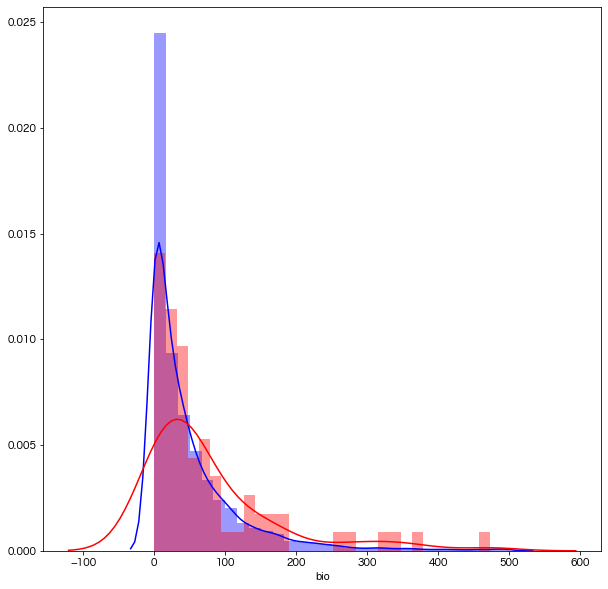

In [6]:
%matplotlib inline
plt.figure(figsize=(10,10))
sns.distplot(unmatch["bio"].apply(lambda w:len(str(w))), color="b", bins=30)
sns.distplot(match["bio"].apply(lambda w:len(str(w))), color="r", bins=30)

In [7]:
def getWord(df):
    retval = []
    for bio in df.bio:
        parse = m.parse(str(bio)).strip().split("\n")
        for p in parse:
            if ("\t" in p) == False:
                continue
            word, desc = p.split("\t")
            if desc.split(",")[0] in ("名詞", "動詞", "形容詞", "形容動詞", "連体詞", "副詞", "接続詞", "感動詞", "記号"):
                retval.append(word)
    return retval

In [8]:
bio_match = getWord(match)
bio_unmatch = getWord(unmatch)

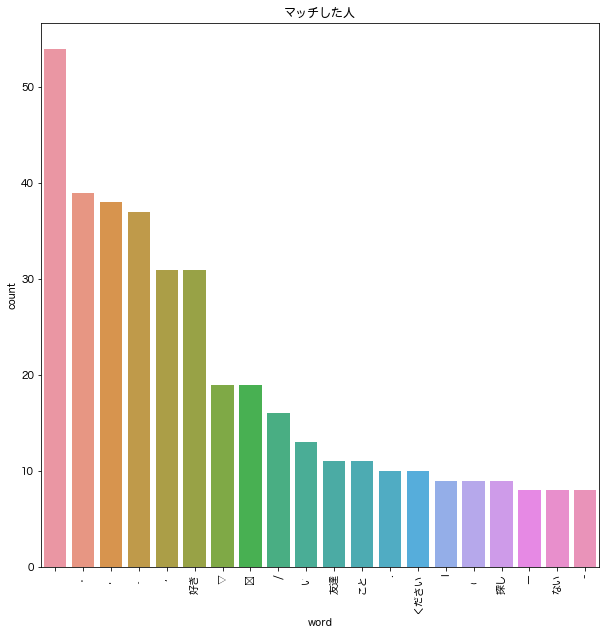

In [9]:
plt.figure(figsize=(10,10))
df_bio_match = pd.DataFrame.from_dict(
    Counter(bio_match), orient="index").reset_index().rename(columns={"index":"word",0:"count"})
sns.barplot(data=df_bio_match.sort_values(
    "count", ascending=False)[:20], x="word", y="count")
plt.xticks(rotation="vertical")
plt.title("マッチした人");

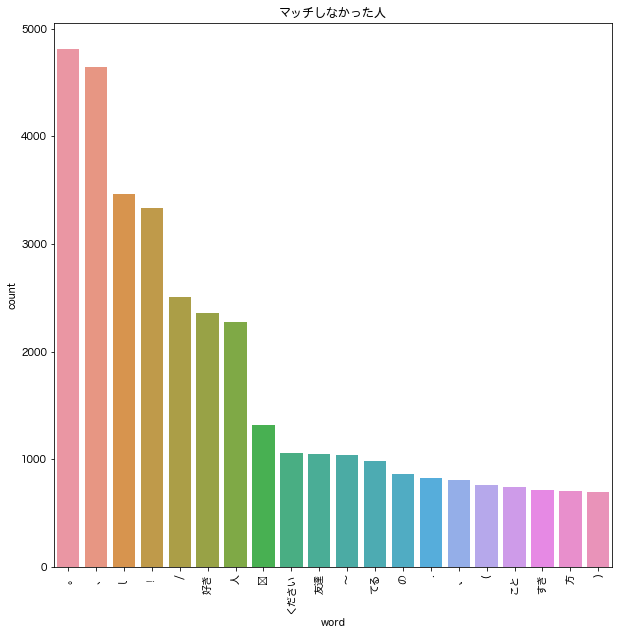

In [10]:
plt.figure(figsize=(10,10))
df_bio_unmatch = pd.DataFrame.from_dict(
    Counter(bio_unmatch), orient="index").reset_index().rename(columns={"index":"word",0:"count"})
sns.barplot(data=df_bio_unmatch.sort_values(
    "count", ascending=False)[:20], x="word", y="count")
plt.xticks(rotation="vertical")
plt.title("マッチしなかった人");

In [11]:
df_train, df_test = train_test_split(df, random_state=8888)

In [12]:
bios=[]
for bio in df_train.bio:
    bio=m_wakati.parse(str(bio)).strip()
    bios.append(bio)

In [13]:
trainings = [TaggedDocument(words = data.split(),tags = [i]) for i,data in enumerate(bios)]

In [14]:
doc2vec = Doc2Vec(documents= trainings, dm = 1, vector_size=300, window=4, min_count=3, workers=4)

In [15]:
X_train = np.array([doc2vec.docvecs[i] for i in range(df_train.shape[0])])
y_train = df_train["match"]

In [16]:
X_test = np.array([doc2vec.infer_vector(m_wakati.parse(str(bio)).split(" ")) for bio in df_test.bio])
y_test = df_test["match"]

In [17]:
pca=PCA()
X_reduced=pca.fit_transform(X_train)

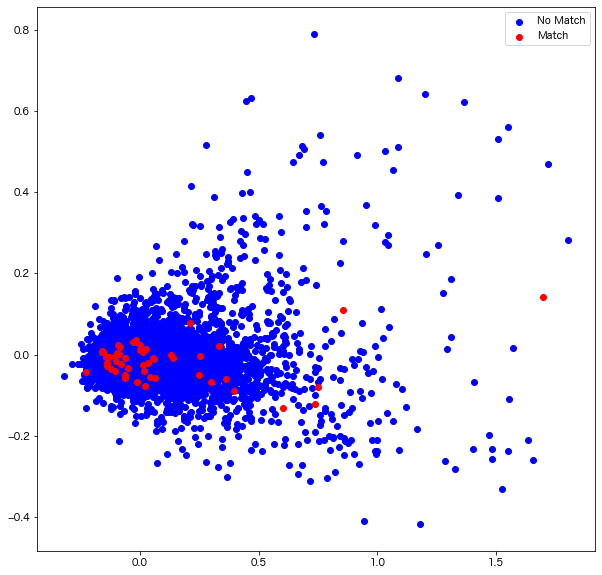

In [18]:
plt.figure(figsize=(10,10))
plt.scatter(X_reduced[y_train==0][:,0], X_reduced[y_train==0][:,1], c="b", label="No Match")
plt.scatter(X_reduced[y_train==1][:,0], X_reduced[y_train==1][:,1], c="r", label="Match")
plt.legend()

In [19]:
X_test_reduced=pca.transform(X_test)

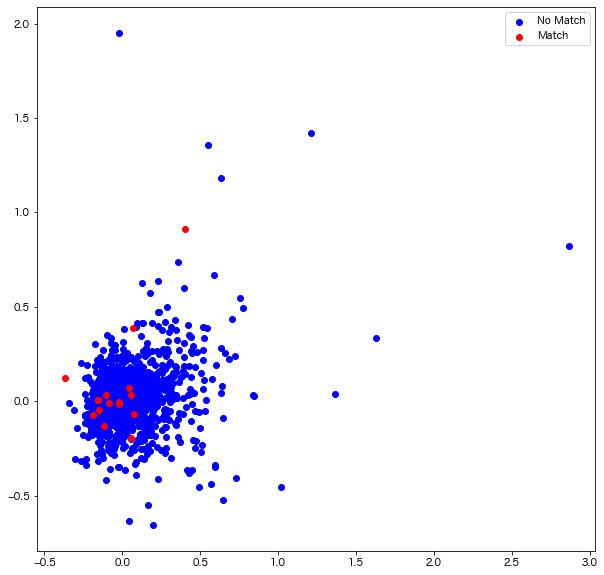

In [20]:
plt.figure(figsize=(10,10))
plt.scatter(X_test_reduced[y_test==0][:,0], X_test_reduced[y_test==0][:,1], c="b", label="No Match")
plt.scatter(X_test_reduced[y_test==1][:,0], X_test_reduced[y_test==1][:,1], c="r", label="Match")
plt.legend()